In [1]:
import numpy as np
import torch
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import primitive
import trimesh

In [2]:
# Loading a mesh and do uniformly samplings on the surface
mesh = trimesh.load_mesh('edge_surface/edge.obj')  # ground truth: [width, length, height] = [10 20 5] 

# Sample points uniformly from the surface of the mesh
points, _ = trimesh.sample.sample_surface_even(mesh, 1000)
points_numpy = np.array(points)
points_tensor = torch.tensor(points_numpy, dtype=torch.float32)

  0%|          | 0/3000 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

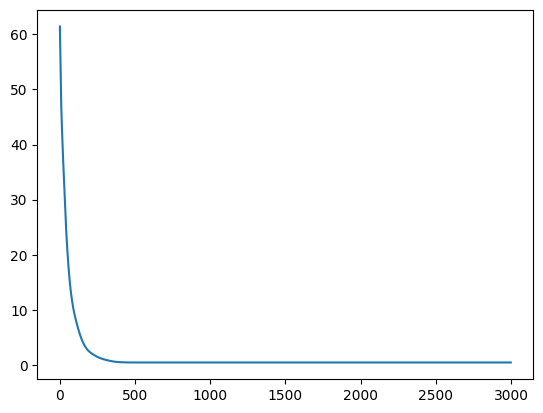

In [3]:
# diff. learning on a certain mesh input
import pytorch3d 
from pytorch3d.loss import chamfer_distance

opt_params = torch.randn(9)
opt_params[-3:] = torch.abs(opt_params[-3:])
opt_params.requires_grad = True

optimizer = torch.optim.Adam([opt_params], 0.1) # 0.1 is a good lr? 10 is not good
uv_coordinates = torch.rand((1000,2))
losses = []

points_tensor = points_tensor.view(1, -1, 3)


for _ in tqdm(range(3000)):
    optimizer.zero_grad()
    opt_points = primitive.cuboid(opt_params, uv_coordinates)
    # opt_points = primitive.hemisphere_withBase(opt_params, uv_coordinates)
    opt_points = opt_points.view(1, -1, 3)
    
    loss = chamfer_distance(x = points_tensor, y = opt_points)
    loss = loss[0]
    
    loss.backward()
    optimizer.step()

    with torch.no_grad(): 
        opt_params[-1] = torch.abs(opt_params[-1]) 

    losses.append(loss.detach().item())
plt.plot(losses)
plt.show


In [4]:
# compare the original mesh with the optimized mesh
points_tensor = points_tensor.reshape(-1, 1, 3)
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':2, 'point_color':'green'})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

1

In [5]:
# check opt_params by plotting original mesh with the points cloud got by opt_params
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

# opt_params is just the final parameters, so we have center, position, radius stored in opt_params
coordinates = torch.rand((1000, 2))
points = primitive.cuboid(opt_params, coordinates).detach().numpy()
plot.add_points(points, shading={'point_size':2, 'point_color':'green'})
print(opt_params)  ## ground truth: [width, length, height] = [10 20 5] , center = [0 0 0], orientation = [0 0 1] (z-axis)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

tensor([-2.4223e-02, -6.6652e-03,  1.2041e-02,  4.5967e-03,  6.5600e-03,
        -2.5865e+00,  9.9342e+00,  1.9866e+01,  4.9846e+00],
       requires_grad=True)
